In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from multiprocessing import Pool

from utils import pattern_utils

In [20]:
colormap = cm.tab10

# Modern Hopfield Network

This model is a generalization of the original Hopfield network and first appeared in an article by Krotov and Hofield in 2016 [1]. 
It considers a new energy function defined as:
\begin{equation*}
  E (\sigma) = - \sum_{\mu = 1}^K F \left( \xi_\mu \cdot \sigma \right)
\end{equation*}
where $\{\xi_{\mu}\}_{\mu=1}^K$ are the $K$ different patterns stored in memory and $\sigma$ is the new pattern we want to know the energy of. 
In the article two different types of function were considered:
- polynomial function of order $n$:
\begin{equation*}
  F(x) = x^n
\end{equation*}
- rectified polynomial function of order $n$:
\begin{equation*}
  F(x) = \left\{
  \begin{array}{lr}
    x^n & x \geq 0 \\
    0 & x < 0
  \end{array}
  \right.
\end{equation*}

We can see how, if we consider $F(x)$ as a polynomial of order 2, the model is equivalent to the original Hopfield network described above.

A new update function was also devised:

\begin{equation*} 
  \sigma^{(t+1)}_i = \mathrm{sign} \left[ \sum_{\mu=1}^K \left( F \left( \xi_i^{\mu} + \sum_{j \neq i} \xi_j^{\mu} \sigma_j^{(t)} \right) 
  - F \left( - \xi_i^{\mu} + \sum_{j \neq i} \xi_j^{\mu} \sigma_j^{(t)} \right) \right) \right]
\end{equation*}

[1] D. Krotov and J. J. Hopfield, "Dense associative memory for pattern recognition" in *Proc. Adv. Neural Inf. Process. Syst.*, vol. 29, 2016, pp. 1172–1180.

In [21]:
class modern_hopfield():
  
  def __init__(self, pattern_lenght: int, func_type: str = "Polyn", poly_order: int = 3):
    """
    Args:
        pattern_lenght (int): number of neurons of the network 
        func_type (str): type of function to evaluate the energy of a single pattern. Possible options are "Polyn", "RePn", "Exp" \n
        poly_order (int): order of the polynomial function used in the evaluation of the energy
    """
    self.pattern_lenght = pattern_lenght
    self.memory_matrix = np.zeros(shape=(1,self.pattern_lenght))
    self.func_type = func_type
    self.n = poly_order
    return
  
  def add_patterns(self, p: np.ndarray):
    """
    Args:
        p (ndarray): pattern to add to memory
    """
    if self.memory_matrix[0,0]==0:
      self.memory_matrix = p
    else:
      self.memory_matrix = np.vstack((self.memory_matrix, p))
    return

  def retrieve_pattern(self, p: np.ndarray, epochs: int):
    """
    Args:
        p (ndarray): input pattern  \n
        epochs (int): maximum number of iterations \n
    performs the update rule up to `epochs` times, trying to match the input pattern `p` to a pattern stored in memory     
    """
    sigma = p.copy()
    for epoch in range(epochs):
      sigma = self._update_rule(sigma)
    return sigma

  def energy(self, sigma: np.ndarray):
    """
    Args:
        sigma (ndarray):
    Computes the energy of the pattern `sigma`
    """
    return - np.sum(self._F(np.dot(self.memory_matrix, sigma)))

  def _update_rule(self, sigma: np.ndarray):
    """
    Args:
        sigma (ndarray): vector containing the values of the network's neurons at time t. \n 
    Returns the values of the network's neurons at time t+1 
    """
    s = 0
    for xi in self.memory_matrix:
      s += self._F(xi + np.dot(xi, sigma) - np.multiply(xi, sigma)) - self._F(-xi + np.dot(xi, sigma) - np.multiply(xi, sigma))
    return np.sign(s)

  def _F(self, x: np.ndarray):
    """
    Energy function used in the update rule. \n
    Different types of function:
    - `Polyn`: polynomial function of order n
    - `RePn`: rectified polynomial function of order n
    - `Exp`: exponential function
    """
    match self.func_type:
      case "Polyn":
        return x**self.n
      case "RePn":
        return np.where(x > 0, x**self.n, 0)
      case "Exp":
        return np.exp(x)
      

# Testing

## Number of maximum patterns retrievable

As stated in the article, the maximum number of patterns this type of network is able to recover without error is:
\begin{equation*}
  K_{\text{no errors}}^{\text{max}} \approx \frac{1}{2 (2 n - 3) !!} \frac{N^{n-1}}{\ln N}
\end{equation*}
where $N$ is the number of neurons. We will now test this finding with our model.

In [42]:
# hyperparameters of the analysis
pattern_lenght = 25
n_patterns = [1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
epochs = 10
max_order = 5
test_size = 20

In [43]:
# we first compute the expected value of k_max given by the formula above 
expected_kmax = []
for d in range(2, max_order+1):
  expected_kmax.append(pattern_utils.maximum_recall(pattern_lenght, d))
expected_kmax = np.array(expected_kmax)
print(expected_kmax)

[  3.88334334  32.36119451 161.80597254 577.87847336]


In [44]:
# we now compute the accuracy of our model in the retrieving task

results = []
for n in range(2, max_order+1):
  accuracy = []
  for L in n_patterns:
    # generating L patterns and saving them to memeory 
    patterns = pattern_utils.generate_patterns(pattern_lenght=pattern_lenght, N=L)
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type="Polyn", poly_order=n)
    model.add_patterns(patterns)

    # we now select a subset of patterns to test our model
    perm = np.random.permutation(patterns.shape[0])
    ts = np.minimum(test_size, L)
    test_patterns = patterns[perm, :][:ts,:]
    
    # computing the accuracy
    acc = 0
    for i, p in enumerate(test_patterns):
      r = model.retrieve_pattern(p=p, epochs=epochs)
      if np.array_equal(test_patterns[i,:], r):
        acc += 1
    acc /= ts
    accuracy.append(acc)
  results.append(accuracy)

results = np.array(results)

print(results)

[[1.   0.1  0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   1.   1.   0.6  0.05 0.05 0.   0.   0.   0.  ]
 [1.   1.   1.   1.   1.   0.75 0.   0.   0.   0.  ]
 [1.   1.   1.   1.   1.   1.   0.85 0.85 0.25 0.  ]]


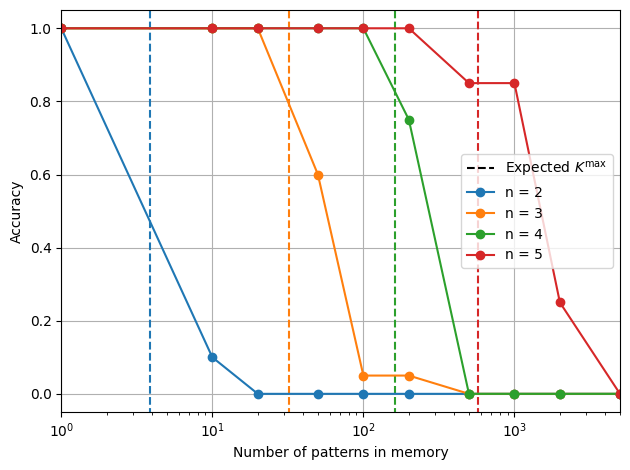

In [45]:
# let's visualize it
fig, ax = plt.subplots()

# plotting of the accuracies
for d in range(max_order - 1):
  ax.errorbar(n_patterns, results[d,:], fmt="o-", alpha=1, label=f"n = {d+2}", color=colormap.colors[d])

# plotting of the expected k_max
for i in range(expected_kmax.shape[0]):
  ax.vlines(expected_kmax[i], ymin=-1, ymax=2, linestyles="--", colors=colormap.colors[i])


# this is just for legend purposes
ax.vlines(0, ymin=0, ymax=0, label=r"Expected $K^{\text{max}}$", linestyles="--", colors='black')


ax.set_xscale('log')
ax.set_xlim(n_patterns[0], n_patterns[-1])
ax.set_ylim(-0.05, 1.05)

ax.set_xlabel("Number of patterns in memory")
ax.set_ylabel("Accuracy")

ax.legend()
ax.grid()

fig.tight_layout()

We can see how our model reproduces the expected behaviour. 

## Corruption
We now want to test the accuracy of our model in retrieving patterns from memory that have been corrupted.
The corruption process utilized consists in flipping any neuron of a pattern with a certain probability $q$. 
Given the nature of our neurons (either having value +1 or -1) we have that the maximum amount of corruption (basically complete randomness) will be reached for $q \sim 0.5$, as we can see that having $q=1$ is equivalent to having the "negative" of the pattern.

### Accuracy w.r.t. function type and corruption

In [26]:
# hyperparameters of the analysis
pattern_lenght = 100
n_patterns = 100
func_type = ["Polyn", "RePn", "Exp"]
poly_order = 7

epochs = 10
test_size = 20
n_trials = 10
corruption_steps = 11

In [27]:
def corruption_func_type_analysis(func_type: str):
  """
  `func_type`: function type to initialize the model \n

  Returns the accuracy of the model for each quantity of corruption. The process is repeated `n_trials` times.
  """

  ts = np.minimum(n_patterns, test_size)

  accuracy = []
  for i in range(n_trials):
    # initialization of the model and creation of the patterns
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_order=poly_order)
    patterns = pattern_utils.generate_patterns(pattern_lenght=pattern_lenght, N=n_patterns)
    model.add_patterns(patterns)

    # we now test our model over different (from 0 to 1) probabilities of corruption
    corruption_prob = np.linspace(0, 1, corruption_steps)
    correctly_identified = []
    for q in corruption_prob:
      # selecting a subset of patterns for testing
      perm = np.random.permutation(patterns.shape[0])
      test_patterns = patterns[perm, :][:ts,:]
      corrupted = pattern_utils.corrupt_patterns(patterns=test_patterns, q=q, corruption_type="Flip")

      # counting how many tests where succesessful
      c_id = 0 
      for i, c in enumerate(corrupted):
        r = model.retrieve_pattern(c, epochs=epochs)
        if np.array_equal(test_patterns[i,:], r): 
          c_id += 1
      correctly_identified.append(c_id)
    accuracy.append(np.array(correctly_identified) / ts)
  return np.array(accuracy)

In [28]:
# multithreading to speed up the process
pool = Pool(len(func_type))
results = pool.map(corruption_func_type_analysis, func_type)

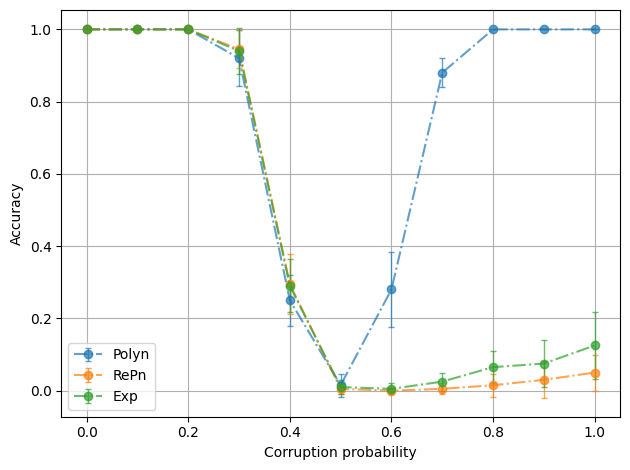

In [29]:
# plotting the results
fig, ax = plt.subplots()

for i, r in enumerate(results):
  ax.errorbar(np.linspace(0,1,corruption_steps), np.mean(r, axis=0), yerr=np.std(r, axis=0), label=func_type[i],
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1, color=colormap.colors[i])

ax.set_xlabel("Corruption probability")
ax.set_ylabel("Accuracy")

ax.legend(loc='lower left')
ax.grid()
fig.tight_layout()

This section tells us that the polynomial function is the best suited for the retrieval task as it is able to effectively reconduct the "negative" of a pattern to the original one stored in memory.
From now on this will be the function used in the analysis, unless stated otherwise.

### Accuracy w.r.t. number of epochs and corruption

In [30]:
# hyperparameters of the analysis
pattern_lenght = 100
n_patterns = 100
func_type = "Polyn"
poly_order = 5

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test_size = 20
n_trials = 10
corruption_steps = 11

In [31]:
def corruption_epochs_analysis(epochs: int):
  """
  `epochs`: number of times the update function is used \n

  Returns the accuracy of the model for each quantity of corruption. The process is repeated `n_trials` times.
  """

  ts = np.minimum(n_patterns, test_size)

  accuracy = []
  for i in range(n_trials):
    # initialization of the model and creation of the patterns
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_order=poly_order)
    patterns = pattern_utils.generate_patterns(pattern_lenght=pattern_lenght, N=n_patterns)
    model.add_patterns(patterns)

    # we now test our model over different (from 0 to 1) probabilities of corruption
    corruption_prob = np.linspace(0, 1, corruption_steps)
    correctly_identified = []
    for q in corruption_prob:
      # selecting a subset of patterns for testing
      perm = np.random.permutation(patterns.shape[0])
      test_patterns = patterns[perm, :][:ts,:]
      corrupted = pattern_utils.corrupt_patterns(patterns=test_patterns, q=q, corruption_type="Flip")

      # counting how many tests where succesessful
      c_id = 0 
      for i, c in enumerate(corrupted):
        r = model.retrieve_pattern(c, epochs=epochs)
        if np.array_equal(test_patterns[i,:], r): 
          c_id += 1
      correctly_identified.append(c_id)
    accuracy.append(np.array(correctly_identified) / ts)
  return np.array(accuracy)

In [32]:
results = []
for e in epochs:
  results.append(corruption_epochs_analysis(e))

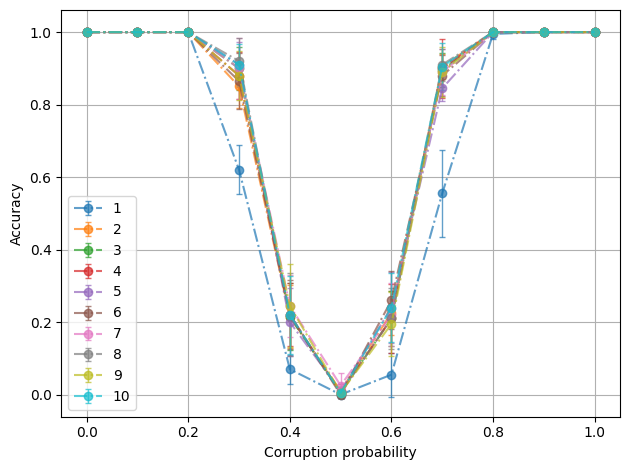

In [33]:
# plotting the results
fig, ax = plt.subplots()

for i, r in enumerate(results):
  ax.errorbar(np.linspace(0,1,corruption_steps), np.mean(r, axis=0), yerr=np.std(r, axis=0), label=f"{epochs[i]}",
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1, color=colormap.colors[i])

ax.set_xlabel("Corruption probability")
ax.set_ylabel("Accuracy")

ax.legend(loc='lower left')
ax.grid()
fig.tight_layout()

### Accuracy w.r.t. number of patterns and corruption

In [34]:
# hyperparameters of the analysis
pattern_lenght = 25
n_patterns = [10, 50, 100, 500, 1000]
func_type = "Polyn"
poly_order = 5

epochs = 10
test_size = 20
n_trials = 10
corruption_steps = 11

In [35]:
def corruption_n_patterns_analysis(n_patterns: int):
  """
  `n_patterns`: number of patterns generated \n

  Returns the accuracy of the model for each quantity of corruption. The process is repeated `n_trials` times.
  """

  ts = np.minimum(n_patterns, test_size)

  accuracy = []
  for _ in range(n_trials):
    # initialization of the model and creation of the patterns
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_order=poly_order)
    patterns = pattern_utils.generate_patterns(pattern_lenght=pattern_lenght, N=n_patterns)
    model.add_patterns(patterns)

    # we now test our model over different (from 0 to 1) probabilities of corruption
    corruption_prob = np.linspace(0, 1, corruption_steps)
    correctly_identified = []
    for q in corruption_prob:
      # selecting a subset of patterns for testing
      perm = np.random.permutation(patterns.shape[0])
      test_patterns = patterns[perm, :][:ts,:]
      corrupted = pattern_utils.corrupt_patterns(patterns=test_patterns, q=q, corruption_type="Flip")

      # counting how many tests where succesessful
      c_id = 0 
      for i, c in enumerate(corrupted):
        r = model.retrieve_pattern(c, epochs=epochs)
        if np.array_equal(test_patterns[i,:], r): 
          c_id += 1
      correctly_identified.append(c_id)
    accuracy.append(np.array(correctly_identified) / ts)
  return np.array(accuracy)

In [36]:
# multithreading to speed up the process
pool = Pool(len(n_patterns))
results = pool.map(corruption_n_patterns_analysis, n_patterns)

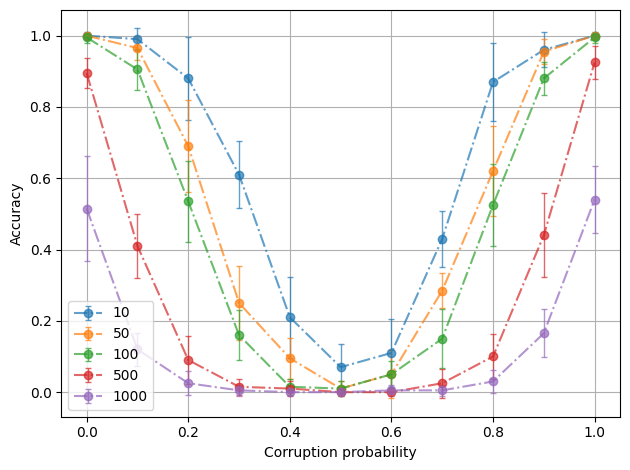

In [37]:
# plotting the results
fig, ax = plt.subplots()

for i, r in enumerate(results):
  ax.errorbar(np.linspace(0,1,corruption_steps), np.mean(r, axis=0), yerr=np.std(r, axis=0), label=f"{n_patterns[i]}",
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1, color=colormap.colors[i])

ax.set_xlabel("Corruption probability")
ax.set_ylabel("Accuracy")

ax.legend(loc='lower left')
ax.grid()
fig.tight_layout()


## Similar energy patterns

Up until now we have considered patterns where the the concentration of spins 

In [38]:
# hyperparameters of the analysis
pattern_lenght = 25
n_patterns = [1, 10, 20, 50, 100, 200, 500, 1000]
func_type = "Polyn"
poly_order = 5

epochs = 10
test_size = 20
n_trials = 10
q_steps = 11

In [39]:
# i want to check the accuracy of the model when the concentration of spins and the number of pattern stored varies
def imbalance_n_patterns_analysis(q: float):

  accuracy = []
  for _ in range(n_trials):
    correcly_identified = []
    for n_p in n_patterns:
      model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_order=poly_order)
      patterns = pattern_utils.generate_patterns(pattern_lenght=pattern_lenght, N=n_p, q=q)
      model.add_patterns(patterns)
  
      ts = np.minimum(n_p, test_size)
      perm = np.random.permutation(n_p)
      test_patterns = patterns[perm, :][:ts,:]

      c_id = 0
      for i, t in enumerate(test_patterns):
        r = model.retrieve_pattern(t, epochs=epochs)
        if np.array_equal(test_patterns[i], r):
          c_id += 1
      correcly_identified.append(c_id / ts)
    accuracy.append(np.array(correcly_identified))
  return np.array(accuracy)          

In [40]:
# multithreading
n1 = 6
n2 = q_steps - n1
q = np.linspace(0, 1, q_steps)
pool = Pool(n1)
results = pool.map(imbalance_n_patterns_analysis, q[:n1])
pool = Pool(n2)
results.extend(pool.map(imbalance_n_patterns_analysis, q[n1:]))

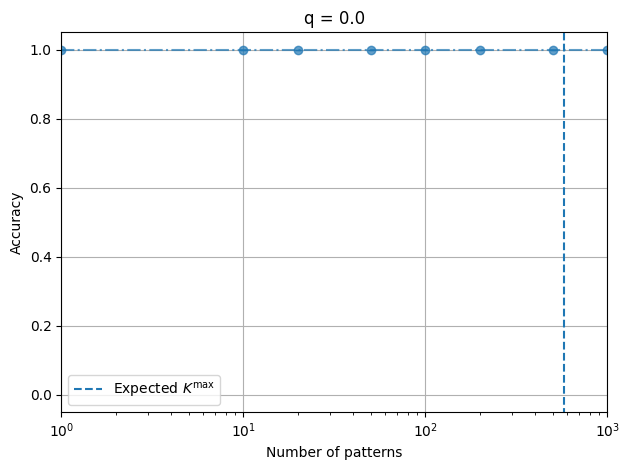

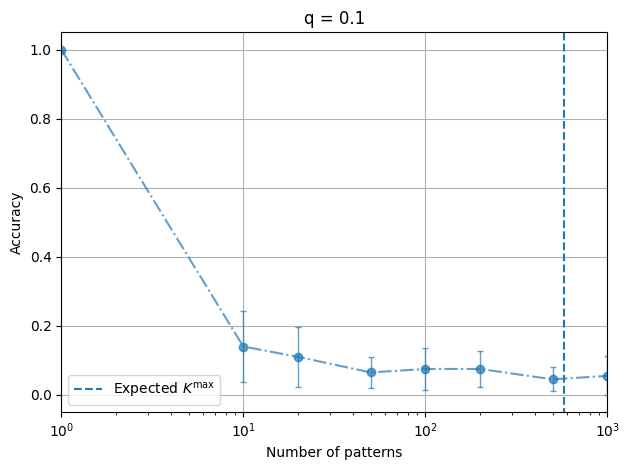

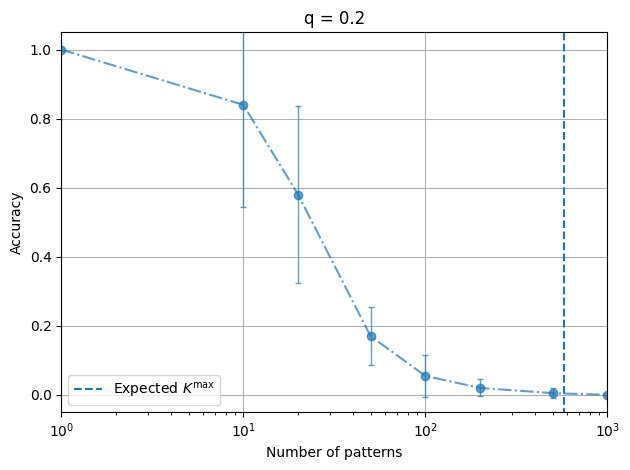

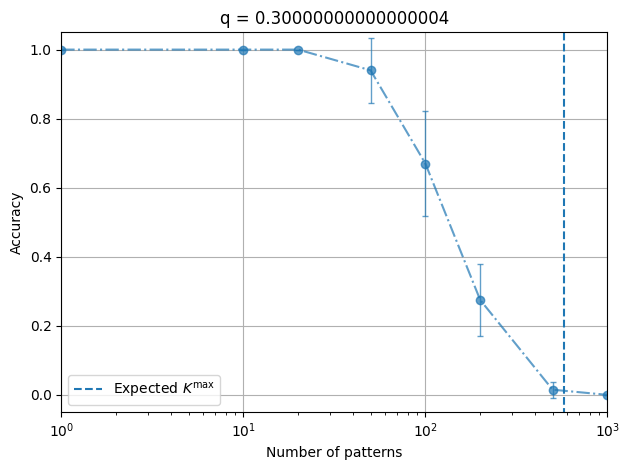

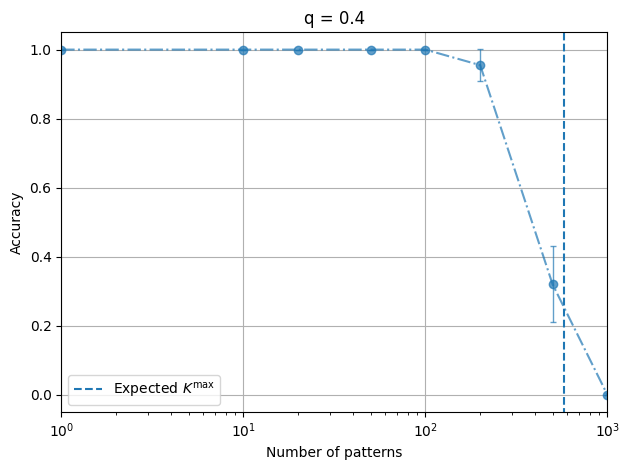

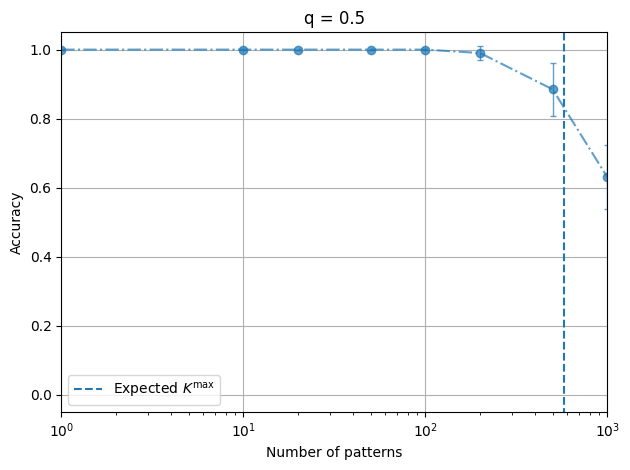

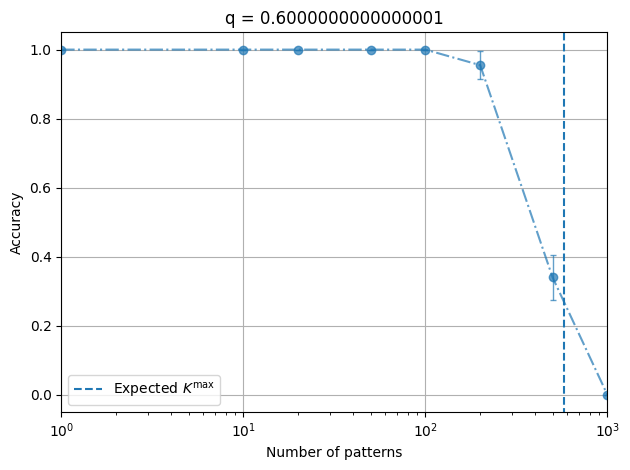

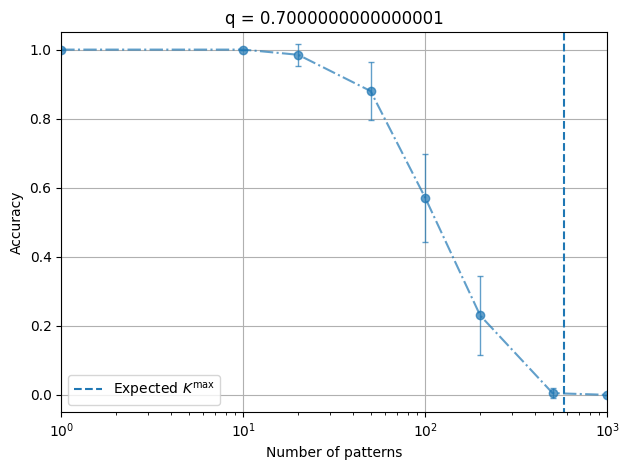

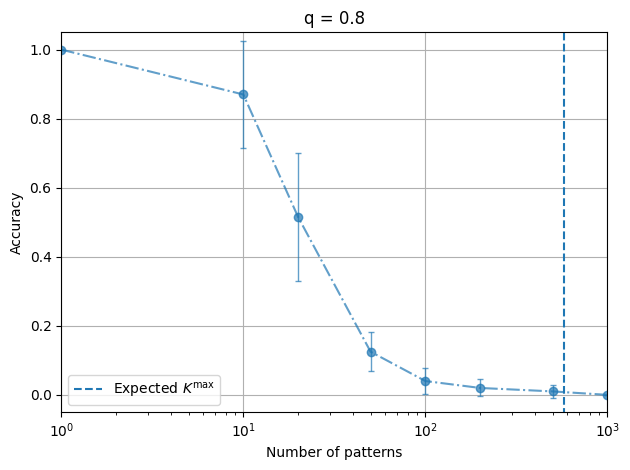

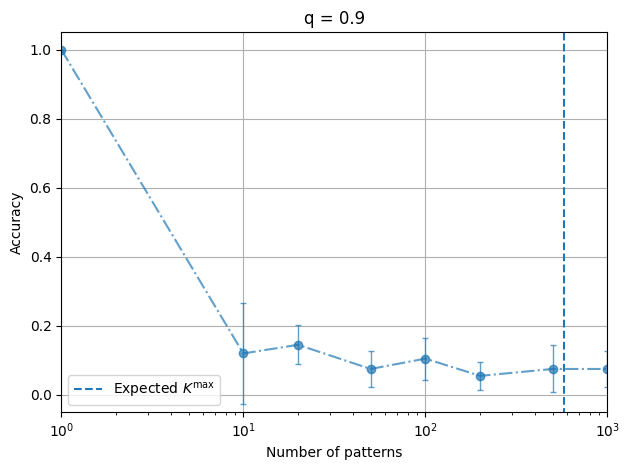

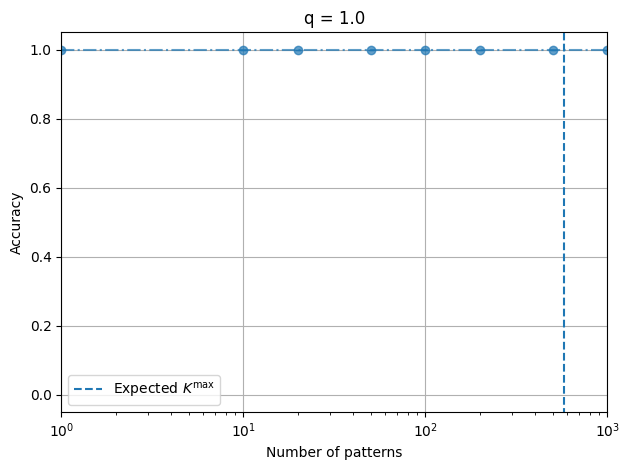

In [41]:
# plotting the results

cmap = cm.RdBu

for i, r in enumerate(results):
  fig, ax = plt.subplots()
  
  ax.errorbar(n_patterns, np.mean(r, axis=0), yerr=np.std(r, axis=0),
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1)
  
  expected_kmax = pattern_utils.maximum_recall(pattern_lenght=pattern_lenght, degree=poly_order)
  ax.vlines(expected_kmax, ymin=-1, ymax=2, label=r"Expected $K^{\text{max}}$", linestyles="--")
  
  ax.legend(loc='lower left')
  ax.set_ylim(-0.05, 1.05)
  ax.set_xlim(n_patterns[0], n_patterns[-1])
  ax.set_xlabel("Number of patterns")
  ax.set_ylabel("Accuracy")
  ax.set_title(f"q = {q[i]}")
  ax.set_xscale('log')
  ax.grid()
  fig.tight_layout()
#fig.tight_layout()